In [1]:
import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)
print("¿Soporte CUDA?:", tf.test.is_built_with_cuda())
print("¿GPU detectada?:", tf.config.list_physical_devices('GPU'))


Versión de TensorFlow: 2.10.0
¿Soporte CUDA?: True
¿GPU detectada?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from __future__ import division
from PIL import Image
import numpy as np
import gym
from gym import ObservationWrapper

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Permute
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [3]:
# Parámetros
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4
ENV_NAME = 'SpaceInvaders-v0'

# Wrapper para corregir salida de env.reset() en versiones recientes de Gym
class GymV21ObservationWrapper(ObservationWrapper):
    def observation(self, obs):
        if isinstance(obs, tuple):
            return obs[0]
        return obs

# Crear entorno con wrapper y semilla
env = GymV21ObservationWrapper(gym.make(ENV_NAME))
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [4]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        # ✅ Desempaquetar si observation es una tupla
        if isinstance(observation, tuple):
            observation = observation[0]

        assert observation.ndim == 3  # (H, W, C)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # Escala de grises
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        return batch.astype('float32') / 255.

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)


In [5]:
#%% Definición de la red neuronal
def build_model(nb_actions):
    model = Sequential()
    model.add(Permute((2, 3, 1), input_shape=(WINDOW_LENGTH,) + INPUT_SHAPE))
    model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    print(model.summary())
    return model



In [6]:
#%% Inicialización de modelo y agente DQN
model = build_model(nb_actions)
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1.0, value_min=0.1, value_test=0.05,
                              nb_steps=1000000)

processor = AtariProcessor()

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=50000, gamma=0.99,
               target_model_update=10000, train_interval=4,
               delta_clip=1.0)

dqn.compile(Adam(learning_rate=0.00025), metrics=['mae'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 84, 84, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [7]:
#%% Configuración de callbacks
weights_filename = f'dqn_{ENV_NAME}_weights.h5f'
checkpoint_weights_filename = f'dqn_{ENV_NAME}_weights_step_{{step}}.h5f'
log_filename = f'dqn_{ENV_NAME}_log.json'

callbacks = [
    ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000),
    FileLogger(log_filename, interval=100)
]


In [8]:
#%% Entrenamiento del modelo
dqn.fit(env, nb_steps=500000, visualize=False, verbose=2, callbacks=callbacks)


Training for 500000 steps ...


c:\Users\valen\anaconda3\envs\dqn_gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    420/500000: episode: 1, duration: 2.129s, episode steps: 420, steps per second: 197, episode reward:  6.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.479 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1131/500000: episode: 2, duration: 2.007s, episode steps: 711, steps per second: 354, episode reward:  7.000, mean reward:  0.010 [ 0.000,  1.000], mean action: 2.415 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1941/500000: episode: 3, duration: 2.333s, episode steps: 810, steps per second: 347, episode reward: 10.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.410 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   2827/500000: episode: 4, duration: 3.358s, episode steps: 886, steps per second: 264, episode reward: 11.000, mean reward:  0.012 [ 0.000,  1.000], mean action: 2.392 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   3345/500000: episode: 5, duration: 2.380s, episode steps: 518, steps per 

c:\Users\valen\anaconda3\envs\dqn_gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


  50138/500000: episode: 73, duration: 18.012s, episode steps: 542, steps per second:  30, episode reward:  3.000, mean reward:  0.006 [ 0.000,  1.000], mean action: 2.541 [0.000, 5.000],  loss: 0.009444, mae: 0.038396, mean_q: 0.072628, mean_eps: 0.954937
  50517/500000: episode: 74, duration: 9.565s, episode steps: 379, steps per second:  40, episode reward:  8.000, mean reward:  0.021 [ 0.000,  1.000], mean action: 2.549 [0.000, 5.000],  loss: 0.004285, mae: 0.034846, mean_q: 0.052399, mean_eps: 0.954705
  51155/500000: episode: 75, duration: 16.065s, episode steps: 638, steps per second:  40, episode reward:  8.000, mean reward:  0.013 [ 0.000,  1.000], mean action: 2.362 [0.000, 5.000],  loss: 0.008045, mae: 0.039779, mean_q: 0.056710, mean_eps: 0.954248
  52111/500000: episode: 76, duration: 24.374s, episode steps: 956, steps per second:  39, episode reward: 22.000, mean reward:  0.023 [ 0.000,  1.000], mean action: 2.474 [0.000, 5.000],  loss: 0.006749, mae: 0.039748, mean_q: 0.

In [11]:
#%% Guardar pesos finales
final_weights = 'dqn_{}_final_weights.h5f'.format(ENV_NAME)
dqn.save_weights(final_weights, overwrite=True)


Testing for 30 episodes ...
Episode 1: reward: 16.000, steps: 810
Episode 2: reward: 9.000, steps: 690
Episode 3: reward: 7.000, steps: 785
Episode 4: reward: 12.000, steps: 614
Episode 5: reward: 11.000, steps: 1022
Episode 6: reward: 11.000, steps: 678
Episode 7: reward: 12.000, steps: 705
Episode 8: reward: 7.000, steps: 639
Episode 9: reward: 15.000, steps: 770
Episode 10: reward: 8.000, steps: 549
Episode 11: reward: 7.000, steps: 757
Episode 12: reward: 22.000, steps: 960
Episode 13: reward: 18.000, steps: 998
Episode 14: reward: 14.000, steps: 828
Episode 15: reward: 14.000, steps: 823
Episode 16: reward: 12.000, steps: 763
Episode 17: reward: 10.000, steps: 672
Episode 18: reward: 19.000, steps: 1209
Episode 19: reward: 13.000, steps: 821
Episode 20: reward: 13.000, steps: 790
Episode 21: reward: 18.000, steps: 1154
Episode 22: reward: 16.000, steps: 974
Episode 23: reward: 15.000, steps: 847
Episode 24: reward: 12.000, steps: 856
Episode 25: reward: 19.000, steps: 1076
Episode

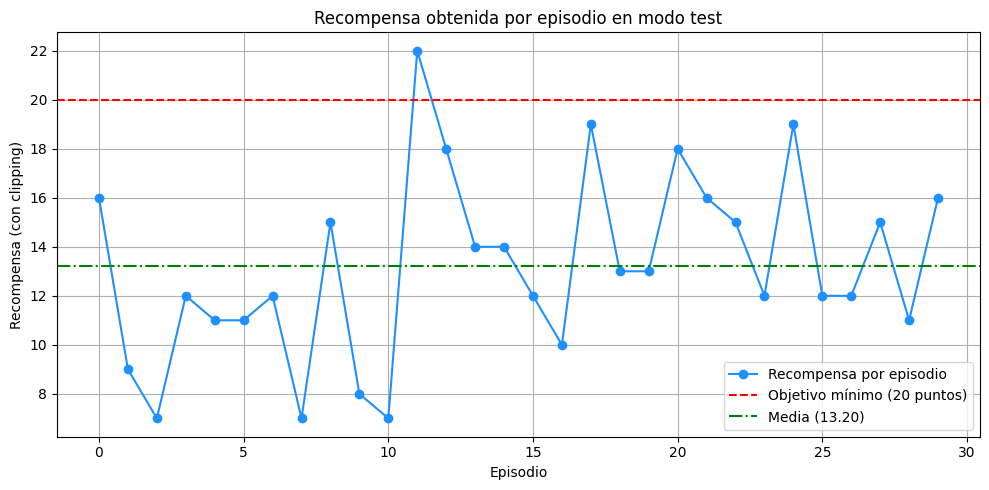

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ================================
# EVALUACIÓN DEL AGENTE ENTRENADO
# ================================

# Cargar pesos finales entrenados
final_weights = 'dqn_SpaceInvaders-v0_final_weights.h5f'
dqn.load_weights(final_weights)

# Evaluar el agente
num_episodios = 30
historial = dqn.test(env, nb_episodes=num_episodios, visualize=False)

# Obtener las recompensas de cada episodio
recompensas = historial.history['episode_reward']
media_recompensas = np.mean(recompensas)

# ================================
# MOSTRAR RESULTADOS
# ================================
print(f"\n🎯 Recompensas por episodio: {recompensas}")
print(f"📊 Media de recompensa sobre {num_episodios} episodios: {media_recompensas:.2f}")
if media_recompensas > 20:
    print("✅ Objetivo cumplido: media de recompensa > 20")
else:
    print("❌ Objetivo no alcanzado: media de recompensa <= 20")

# ================================
# GRAFICAR RESULTADOS
# ================================
plt.figure(figsize=(10, 5))
plt.plot(recompensas, marker='o', linestyle='-', color='dodgerblue', label='Recompensa por episodio')
plt.axhline(y=20, color='red', linestyle='--', label='Objetivo mínimo (20 puntos)')
plt.axhline(y=media_recompensas, color='green', linestyle='-.', label=f'Media ({media_recompensas:.2f})')
plt.title('Recompensa obtenida por episodio en modo test')
plt.xlabel('Episodio')
plt.ylabel('Recompensa (con clipping)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cerrar entorno
env.close()


In [17]:
dqn.load_weights('dqn_SpaceInvaders-v0_final_weights.h5f')
dqn.policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                                  attr='eps',
                                  value_max=1.0,
                                  value_min=0.05,   # puedes probar con 0.01 si ya aprendió bastante
                                  value_test=0.01,
                                  nb_steps=1000000)

In [20]:
# ================================
# ENTRENAMIENTO ADICIONAL (100K)
# ================================
dqn.fit(env, nb_steps=100000, visualize=False, verbose=2,
        callbacks=callbacks)

# Guardar pesos nuevos finales
dqn.save_weights('dqn_SpaceInvaders-v0_final_weights_600k.h5f', overwrite=True)

Training for 100000 steps ...
   781/100000: episode: 1, duration: 3.711s, episode steps: 781, steps per second: 210, episode reward: 13.000, mean reward:  0.017 [ 0.000,  1.000], mean action: 2.415 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1416/100000: episode: 2, duration: 3.000s, episode steps: 635, steps per second: 212, episode reward:  9.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.556 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1786/100000: episode: 3, duration: 1.816s, episode steps: 370, steps per second: 204, episode reward:  4.000, mean reward:  0.011 [ 0.000,  1.000], mean action: 2.638 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  2502/100000: episode: 4, duration: 3.445s, episode steps: 716, steps per second: 208, episode reward: 10.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.483 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  3469/100000: episode: 5, duration: 4.888s, episo

Testing for 30 episodes ...
Episode 1: reward: 13.000, steps: 652
Episode 2: reward: 18.000, steps: 1299
Episode 3: reward: 14.000, steps: 723
Episode 4: reward: 18.000, steps: 1055
Episode 5: reward: 10.000, steps: 560
Episode 6: reward: 20.000, steps: 1159
Episode 7: reward: 19.000, steps: 1043
Episode 8: reward: 22.000, steps: 939
Episode 9: reward: 12.000, steps: 655
Episode 10: reward: 8.000, steps: 525
Episode 11: reward: 8.000, steps: 609
Episode 12: reward: 21.000, steps: 891
Episode 13: reward: 12.000, steps: 646
Episode 14: reward: 14.000, steps: 805
Episode 15: reward: 14.000, steps: 854
Episode 16: reward: 7.000, steps: 491
Episode 17: reward: 11.000, steps: 615
Episode 18: reward: 19.000, steps: 913
Episode 19: reward: 10.000, steps: 553
Episode 20: reward: 10.000, steps: 506
Episode 21: reward: 20.000, steps: 724
Episode 22: reward: 12.000, steps: 809
Episode 23: reward: 16.000, steps: 703
Episode 24: reward: 13.000, steps: 666
Episode 25: reward: 9.000, steps: 682
Episod

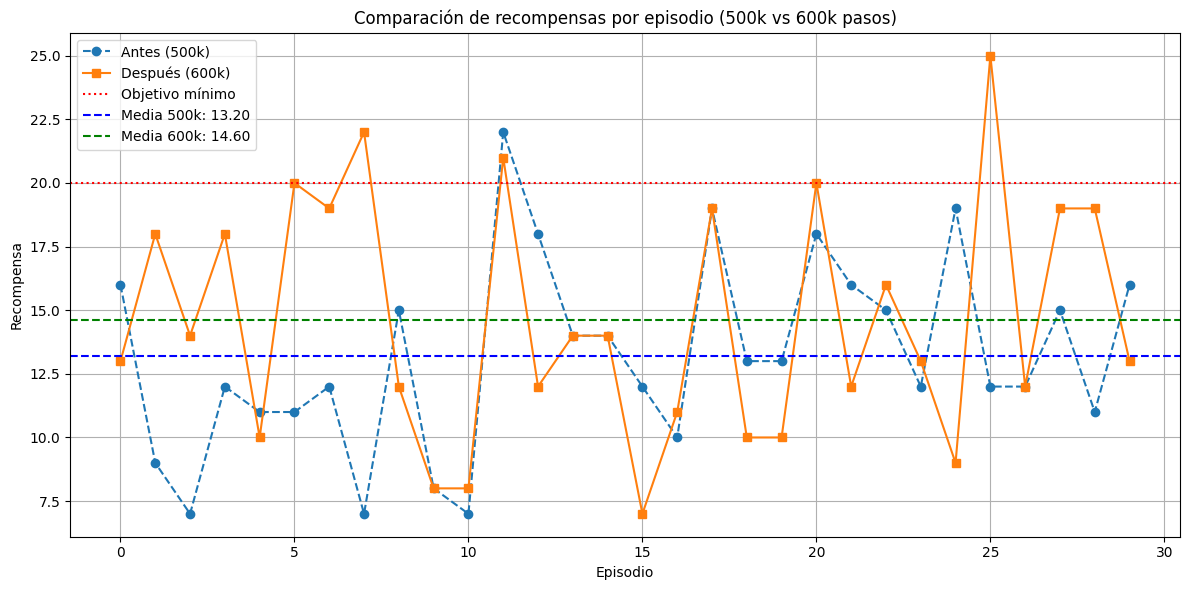

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Cargar nuevos pesos 
dqn.load_weights('dqn_SpaceInvaders-v0_final_weights_600k.h5f')

# Evaluación con nuevos pesos
num_episodios = 30
nuevo_historial = dqn.test(env, nb_episodes=num_episodios, visualize=False)
nuevas_recompensas = nuevo_historial.history['episode_reward']
media_nueva = np.mean(nuevas_recompensas)

# Aquí pega tus recompensas anteriores manualmente:
recompensas_anteriores = [16.0, 9.0, 7.0, 12.0, 11.0, 11.0, 12.0, 7.0, 15.0, 8.0, 7.0, 22.0, 18.0, 14.0, 14.0, 12.0, 10.0, 19.0, 13.0, 13.0, 18.0, 16.0, 15.0, 12.0, 19.0, 12.0, 12.0, 15.0, 11.0, 16.0]
media_anterior = np.mean(recompensas_anteriores)

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(recompensas_anteriores, label='Antes (500k)', marker='o', linestyle='--')
plt.plot(nuevas_recompensas, label='Después (600k)', marker='s', linestyle='-')
plt.axhline(20, color='red', linestyle=':', label='Objetivo mínimo')
plt.axhline(media_anterior, color='blue', linestyle='--', label=f'Media 500k: {media_anterior:.2f}')
plt.axhline(media_nueva, color='green', linestyle='--', label=f'Media 600k: {media_nueva:.2f}')
plt.title("Comparación de recompensas por episodio (500k vs 600k pasos)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
print(f"\n🎯 Recompensas por episodio: {recompensas}")
print(f"📊 Media de recompensa sobre {num_episodios} episodios: {media_nueva:.2f}")
if media_nueva > 20:
    print("✅ Objetivo cumplido: media de recompensa > 20")
else:
    print("❌ Objetivo no alcanzado: media de recompensa <= 20")


🎯 Recompensas por episodio: [16.0, 9.0, 7.0, 12.0, 11.0, 11.0, 12.0, 7.0, 15.0, 8.0, 7.0, 22.0, 18.0, 14.0, 14.0, 12.0, 10.0, 19.0, 13.0, 13.0, 18.0, 16.0, 15.0, 12.0, 19.0, 12.0, 12.0, 15.0, 11.0, 16.0]
📊 Media de recompensa sobre 30 episodios: 14.60
❌ Objetivo no alcanzado: media de recompensa <= 20


In [ ]:
# ================================
# ENTRENAMIENTO CONTINUADO (1.5M pasos adicionales)
# ================================

# Cargar pesos previos del modelo entrenado hasta 500k pasos
dqn.load_weights('dqn_SpaceInvaders-v0_final_weights_600k.h5f')

# Ajuste de hiperparámetros antes de continuar (opcional)
dqn.target_model_update = 5000  # Actualizar target model más frecuentemente

# Redefinir callbacks para guardado y logging
checkpoint_callback = ModelIntervalCheckpoint(
    filepath='dqn_SpaceInvaders-v0_step_{step}.h5f',
    interval=100000,  # Guarda cada 100k pasos
    verbose=1
)

log_callback = FileLogger('dqn_SpaceInvaders-v0_log_continued.json', interval=10000)

# Entrenamiento adicional
print("Entrenando modelo desde paso 500k hasta 2M...")
dqn.fit(env, nb_steps=1500000, visualize=False, verbose=2, callbacks=[checkpoint_callback, log_callback])

# Guardar pesos finales tras entrenamiento extendido
final_weights_extended = 'dqn_SpaceInvaders-v0_final_weights_extendido.h5f'
dqn.save_weights(final_weights_extended, overwrite=True)


Entrenando modelo desde paso 500k hasta 2M...
Training for 1500000 steps ...
     576/1500000: episode: 1, duration: 2.733s, episode steps: 576, steps per second: 211, episode reward:  8.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.450 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
     941/1500000: episode: 2, duration: 1.798s, episode steps: 365, steps per second: 203, episode reward:  5.000, mean reward:  0.014 [ 0.000,  1.000], mean action: 2.378 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    2423/1500000: episode: 3, duration: 7.397s, episode steps: 1482, steps per second: 200, episode reward: 12.000, mean reward:  0.008 [ 0.000,  1.000], mean action: 2.547 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    3177/1500000: episode: 4, duration: 3.527s, episode steps: 754, steps per second: 214, episode reward: 11.000, mean reward:  0.015 [ 0.000,  1.000], mean action: 2.443 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mea